In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import html5lib
import datetime
import requests
sns.set_style("whitegrid")

### How To:
Simple run the notebook and insert the page content (STRG+A, STRG+C) into the input field.
You will find the grades here: [KIT Einstufungstabelle](https://www.sle.kit.edu/nachstudium/ects-einstufungstabellen.php)

In [2]:
def drawECDF():
    run:bool = True
    i:int = 0

    # Save dataframes, major and time period here
    df_list = []
    major_list = []
    time_period_list = []
    major_and_time_period_list = []

    while run:
        i = i + 1
        # Get input (STRG+A and STRG+C to copy all content)
        raw = input("Please enter site content (STRG+A, STRG+C): ")

        # If empty input break loop
        if raw == "":
            run = False
            print(f"Reading ended after {i - 1} iterations\n")
            break

        # Read clipboard
        df = pd.read_clipboard(raw, decimal=",")
        # Drop row with "international"
        df = df[df["Quelle: Dienstleistungseinheit Studium und Lehre"] != "(international)"]

        # Get major and time information
        major = " ".join(df.iloc[1,0].split(": ")[1:])
        time = " ".join(df.iloc[2,0].split(": ")[1:])

        # Keep only grades and percentage information and transform
        df_prime = df.copy()
        df_prime = df_prime[4:]
        df_prime[['Grade', 'Percentage']] = df_prime['Quelle: Dienstleistungseinheit Studium und Lehre'].str.split(' ',n=1, expand=True)
        df_prime = df_prime[["Grade", "Percentage"]]
        df_prime["Grade"] = df_prime["Grade"].apply(lambda x: x.replace(",", ".")).astype(float)
        df_prime["Percentage"] = df_prime["Percentage"].apply(lambda x: x.replace(",", ".")).astype(float)

        # Compute cumulative sum
        df_prime["Cum. Percentage"] = df_prime["Percentage"].cumsum()
        # Drop Percentage
        df_prime.drop("Percentage", axis=1, inplace=True)

        # Save finalized df in df_list outside of the loop
        df_list.append(df_prime)
        major_list.append(major)
        time_period_list.append(time)
        major_and_time_period_list.append(major + ": " + time)

    return df_list, major_list, time_period_list, major_and_time_period_list

# Call function and get data
df_list, major_list, time_period_list, major_and_time_period_list = drawECDF()

Reading ended after 5 iterations



## Plotting

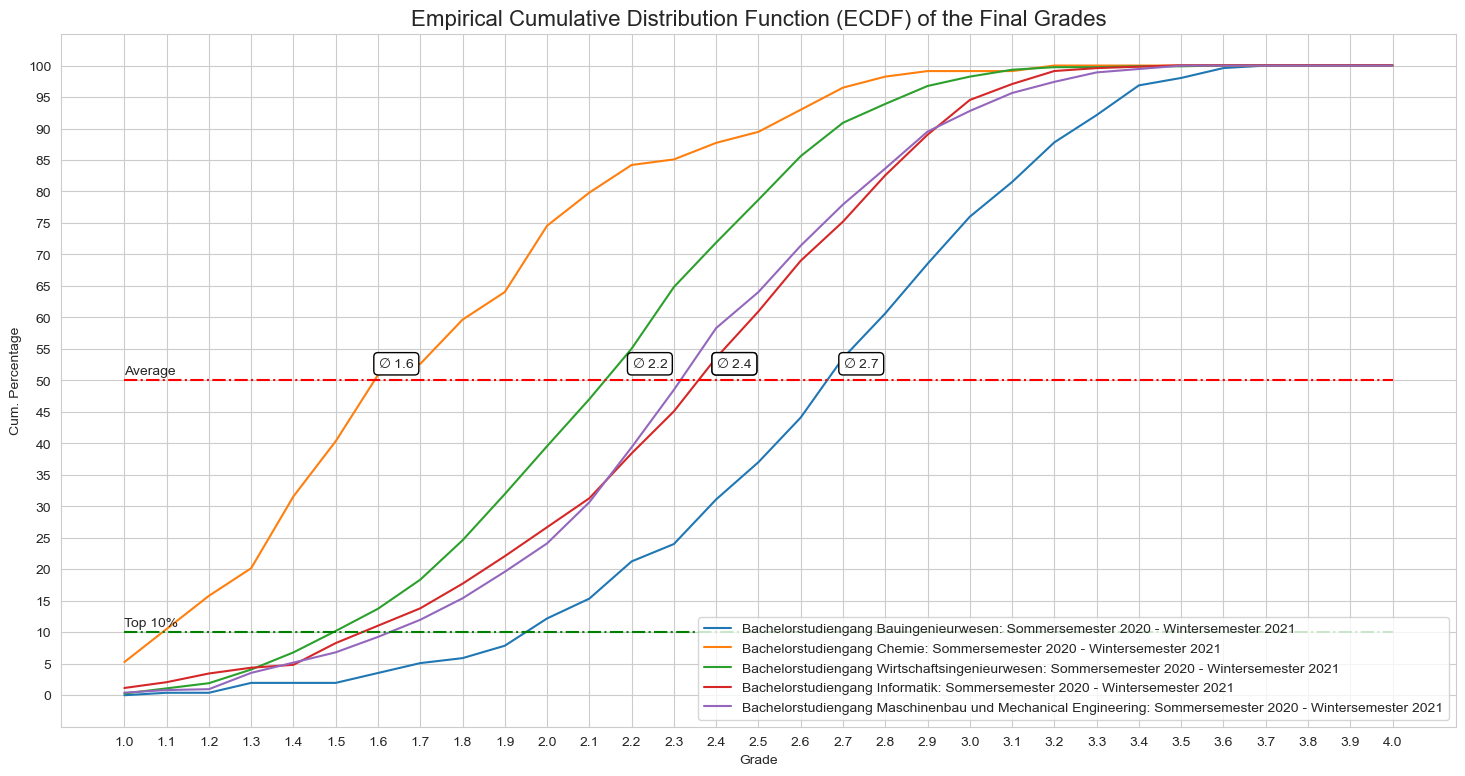

In [20]:
# Plot and Plot Settings
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
plt.title("Empirical Cumulative Distribution Function (ECDF) of the Final Grades", size=16)
for df, information in zip(df_list, major_and_time_period_list):
    sns.lineplot(data=df, x="Grade", y="Cum. Percentage", legend=True, ax=ax, label=information)
    # Get mean grade
    mean = df[df["Cum. Percentage"] >= 50.0].iloc[0, 0]
    # Annotate mean grade in plot
    plt.annotate(text=f"$\emptyset$ {mean}", xy=(mean, 50+2), bbox=dict(boxstyle="round", edgecolor="black", pad=0.3, fc="w"))
plt.xticks(np.arange(1, 4.1, 0.1))
plt.yticks(np.arange(0, 105, 5))
# Draw average line
plt.annotate(text="Average", xy=(1.0, 51.0))
plt.hlines(y=50, color = "red", linestyles="-.", xmin=1, xmax=4)
# Draw top10 line
plt.annotate(text="Top 10%", xy=(1.0, 11.0))
plt.hlines(y=10, color = "green", linestyles="-.", xmin=1, xmax=4)
plt.savefig(f"figures/figure_{str(datetime.datetime.now()).replace(':', '').strip()}.png", dpi=256, bbox_inches='tight')
plt.show()